In [49]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread
from PIL import Image

import torch
import torch.utils.data as data_utils
from torch.autograd import Variable

%matplotlib inline

## Load Pair List

In [52]:
with open('./im2latex_train.lst','rb') as file:
    match = file.readlines()

In [53]:
N = len(match)
print ("Number of data: ",N )

Number of data:  83884


(285, 41)


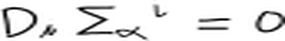

In [56]:
img = Image.open('./data/handwritten_processed/' + '81680.png')
print (img.size)
img

(285, 41)


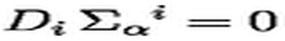

In [71]:
img2 = Image.open('./data/latex_processed/' + match_dict['81680.png'])
img2 = img2.resize((285, 41), Image.ANTIALIAS)
print (img2.size)
img2

## Split train and test

**2 img sizes: 
(41,285) for train, 
(40,253) for test**

In [7]:
threshold = 150 

In [8]:
def to_bin(img, up):
    img_copy = np.copy(img)
    img_copy[img_copy <= threshold] = 0
    img_copy[img_copy > threshold] = up
    return img_copy

In [34]:
def load_train_test(match_dict, n_train = 1000, n_test = 200):
    
    '''
    to do: check valide number of data
    '''
    hw_train, print_train = [], []
    hw_test, print_test = [], []
    
    i_train, i_test = 0, 0
    
    print ("Loading data ...")
    
    for i,hw in enumerate(list(match_dict.keys())[:200]):
        

        #load matched filenames
        pr = match_dict[hw]
        
        try:
            #print
            print_img = Image.open('./data/latex_processed/'+pr)
            print_img_bin = to_bin(print_img,up=1)

            #handwritten
            hw_img = Image.open('./data/handwritten_processed/'+hw)
            hw_img_bin = to_bin(hw_img,up=1)
#             print (hw_img_bin.shape)
        
        
            if (hw_img_bin.shape == (41, 285)):
                
                hw_train.append(hw_img_bin)
                print_train.append(print_img_bin)
                
                
            if (hw_img_bin.shape == (40, 253)):
                
                hw_test.append(hw_img_bin)
                print_test.append(print_img_bin)
#                 i_test += 1

        except:
            #no such image
            pass
        
#         if (i_train == n_train) and (i_test == n_test):
#             print ("Data successfully loaded")
            
    hw_train = np.array(hw_train, dtype = 'float')
    print_train = np.array(print_train, dtype = 'float')
    hw_test = np.array(hw_test, dtype = 'float')
    print_test = np.array(print_test, dtype = 'float')


    hw_train = np.expand_dims(hw_train, axis=1)
    print_train = np.expand_dims(print_train, axis=1)
    hw_test = np.expand_dims(hw_test, axis=1)
    print_test = np.expand_dims(print_test, axis=1)
            
    return hw_train, print_train, hw_test, print_test
            

In [35]:
match_dict = {e.decode('utf-8').split(' ')[0] + '.png':e.decode('utf-8').split(' ')[1] + '.png' for e in match}

In [36]:
hw_train, print_train, hw_test, print_test = load_train_test(match_dict, n_train=10, n_test = 20)   

Loading data ...


In [37]:
print_train.shape

(186, 1, 40, 253)

In [38]:
print_test.shape

(0, 1)

In [39]:
hw_train.shape

(186, 1, 41, 285)

In [40]:
hw_test.shape

(0, 1)

In [ ]:
features = torch.from_numpy(hw_imgs_3d).type(torch.FloatTensor)
targets = torch.from_numpy(print_imgs_3d).type(torch.FloatTensor)

batch_size = 40 #整数倍个数

train = data_utils.TensorDataset(features, targets)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

**It is a Grey scale picture = RGB 3 channel the same both for handwritten and pdf**

### Train DVE

In [354]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [366]:
epoch = 10
learning_rate = 0.001

In [356]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 1 x 28 x 28 -> batch x 512

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 16 x max_height x max_weight
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x max_height x max_weight
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x max_height x max_weight
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 32 x max_height x max_weight
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x max_height x max_weight / 4
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder()

In [357]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
#         self.layer1 = nn.Sequential(
#                         nn.ConvTranspose2d(256,128,3,2,1,1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#                         nn.ConvTranspose2d(128,128,3,1,1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#                         nn.ConvTranspose2d(128,64,3,1,1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#                         nn.ConvTranspose2d(64,64,3,1,1),
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64)
#         )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,64,int(max_height/2),int(max_width/2))
#         out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder()

In [ ]:
# Check output of autoencoder
#ignore
for image,label in train_loader:
    image = Variable(image)
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

In [ ]:
# Noise
#ignore
noise = torch.rand(batch_size,1,28,28)

In [367]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.BCEWithLogitsLoss(weight=0.1*torch.ones(40,1,50,300)) #40 is batch size
# m = nn.Sigmoid()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [368]:
loss_arr = []
for i in range(1):
    for image,label in train_loader:
  
        optimizer.zero_grad()
        output = encoder(Variable(image))
        output = decoder(output)
        
        loss = loss_func(output,Variable(label))
        loss.backward()
        optimizer.step()       
                
#     torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
        print("i",loss.data.numpy()[0])
        loss_arr.append(loss.data.numpy()[0])

i 0.0669711
i 0.0670275
i 0.0659771
i 0.0652752
i 0.0646452
i 0.0640354
i 0.0634396
i 0.0628764
i 0.0623596
i 0.0617148
i 0.0614523
i 0.0608557
i 0.060338
i 0.0597419
i 0.059331
i 0.0587418
i 0.0582503
i 0.0578348
i 0.0573265
i 0.056864
i 0.0563885
i 0.0560859
i 0.055491
i 0.0550824
i 0.0546494
i 0.0543248
i 0.0539544
i 0.0536007
i 0.0532652
i 0.0527231
i 0.0523514
i 0.0520944
i 0.0515517
i 0.0511115
i 0.0511176
i 0.050666
i 0.050351
i 0.0500816
i 0.0496794
i 0.0496286
i 0.0492746
i 0.0487951
i 0.0488936
i 0.0486606
i 0.0483163
i 0.0480904
i 0.047915
i 0.0477528
i 0.047526
i 0.0472998
i 0.047077
i 0.0473448
i 0.0470505
i 0.0465657


In [369]:
def to_RGB(img):
    img[img <=0.5] = 0
    img[img > 0.5] = 255
    return img

In [370]:
def compare_plot(label, image, output):
        
    img = label[0]
    input_img = image[0]
    output_img = output[0]

    origin = img.numpy().astype(int)
    input_img = input_img.numpy().astype(int)
    output_img = to_RGB(output_img.data.numpy().astype(int))

    plt.imshow(origin[0,:,:],cmap='gray')
    plt.show()

    plt.imshow(input_img[0,:,:],cmap='gray')
    plt.show()

    plt.imshow(output_img[0,:,:],cmap="gray")
    plt.show()

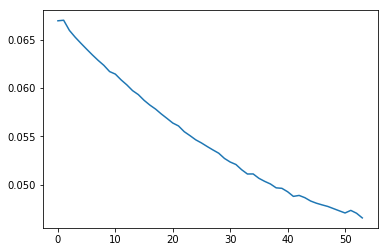

In [371]:
plt.plot(range(len(loss_arr)), loss_arr)
plt.show()

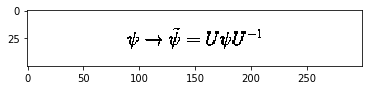

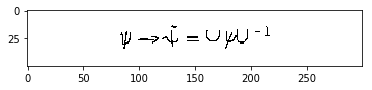

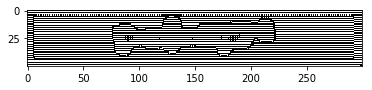

In [372]:
compare_plot(label, image, output)

In [373]:
loss_arr = []
for i in range(1):
    for image,label in train_loader:
  
        optimizer.zero_grad()
        output = encoder(Variable(image))
        output = decoder(output)
        
        loss = loss_func(output,Variable(label))
        loss.backward()
        optimizer.step()       
                
#     torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
        print("i",loss.data.numpy()[0])
        loss_arr.append(loss.data.numpy()[0])

i 0.0467401
i 0.046434
i 0.0463232
i 0.0467601
i 0.0461716
i 0.0458464
i 0.0458656
i 0.0455698
i 0.0457835
i 0.0453655
i 0.04524
i 0.0452142
i 0.0448129
i 0.0449174
i 0.0451547
i 0.0450719
i 0.0448199
i 0.0445889
i 0.0444118
i 0.0443762
i 0.044508
i 0.0441414
i 0.0442511
i 0.0438415
i 0.0439553
i 0.0438697
i 0.0440794
i 0.0440791
i 0.0441256
i 0.043701
i 0.0434799
i 0.0435257
i 0.0431783
i 0.0432269
i 0.0433167
i 0.0432329
i 0.0432762
i 0.0433459
i 0.0433255
i 0.042848
i 0.0436767
i 0.0430445
i 0.0428232
i 0.0427634
i 0.0430581
i 0.0427207
i 0.042746
i 0.0427195
i 0.0425508
i 0.0425293
i 0.0425256
i 0.0423942
i 0.0426572
i 0.0421035


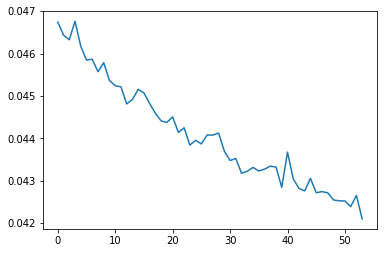

In [375]:
plt.plot(range(len(loss_arr)), loss_arr)
plt.show()

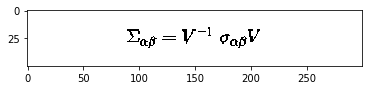

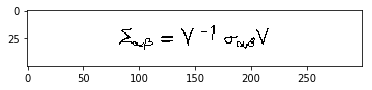

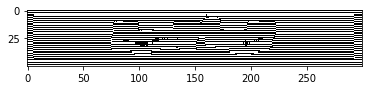

In [374]:
compare_plot(label, image, output)

In [ ]:
loss_arr = []
for i in range(10):
    for image,label in train_loader:
  
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(Variable(image))
        output = decoder(output)
        loss = loss_func(output,Variable(label))
        loss.backward()
        optimizer.step()    
                
#     torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
        print("i",loss.data.numpy()[0])
        loss_arr.append(loss.data.numpy()[0])

In [ ]:
plt.plot(range(len(loss_arr)), loss_arr)
plt.show()

In [ ]:
compare_plot(label, image, output)

### Train VAE

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [ ]:
batch_size = 100
epochs = 10
log_interval = 10

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(1000*300, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 1000*300)
        
        #convolution
#         self.fc1 = nn.Conv3d(3,10,3)
#         self.fc21 = nn.Conv3d(10,15,3)
#         self.fc22 = nn.Linear(400, 20)
#         self.fc3 = nn.Linear(20, 400)
#         self.fc4 = nn.Linear(400, 1000*100)
        #linear
#         self.fc1 = nn.Linear(1000*100, 400)
#         self.fc21 = nn.Linear(400, 20)
#         self.fc22 = nn.Linear(400, 20)
#         self.fc3 = nn.Linear(20, 400)
#         self.fc4 = nn.Linear(400, 1000*100)

        self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool3d((2, 2, 2))
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1000*300))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1000*300))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * 1000*300

    return BCE + KLD

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.type(torch.FloatTensor))
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        data = Variable(data.type(torch.FloatTensor), volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
model = VAE()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
#     test(epoch)
#     sample = Variable(torch.randn(64, 20))
#     sample = model.decode(sample).cpu()
#     save_image(sample.data.view(64, 1, 28, 28),
#                'results/sample_' + str(epoch) + '.png')